<a href="https://colab.research.google.com/github/Dhanasree-Rajamani/Deep_Learning_Assignments/blob/main/Assignment_7/Image_Classification_BiT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Import Requirements

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

SEEDS = 42

np.random.seed(SEEDS)
tf.random.set_seed(SEEDS)

###Flower dataset

In [2]:
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True,
)

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


###Visualize dataset

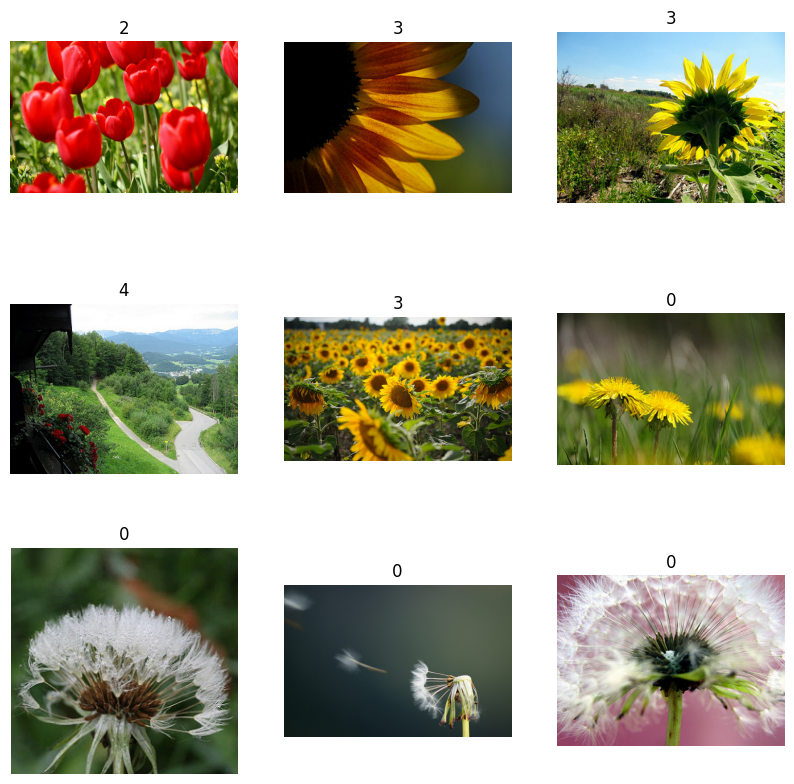

In [3]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

###Define Hyperparameters

In [4]:
RESIZE_TO = 384
CROP_TO = 224
BATCH_SIZE = 64
STEPS_PER_EPOCH = 10
AUTO = tf.data.AUTOTUNE  # optimise the pipeline performance
NUM_CLASSES = 5  # number of classes
SCHEDULE_LENGTH = (
    500  # we will train on lower resolution images and will still attain good results
)
SCHEDULE_BOUNDARIES = [
    200,
    300,
    400,
]  # more the dataset size the schedule length increase

###Define Preprocessing Helper functions

In [5]:
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE


@tf.function
def preprocess_train(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
    image = image / 255.0
    return (image, label)


@tf.function
def preprocess_test(image, label):
    image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = image / 255.0
    return (image, label)


DATASET_NUM_TRAIN_EXAMPLES = train_ds.cardinality().numpy()

repeat_count = int(
    SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH
)
repeat_count += 50 + 1  # To ensure at least there are 50 epochs of training

###Data Pipeline

In [6]:
# Training pipeline
pipeline_train = (
    train_ds.shuffle(10000)
    .repeat(repeat_count)  # Repeat dataset_size / num_steps
    .map(preprocess_train, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Validation pipeline
pipeline_validation = (
    validation_ds.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

###Visualize the training samples

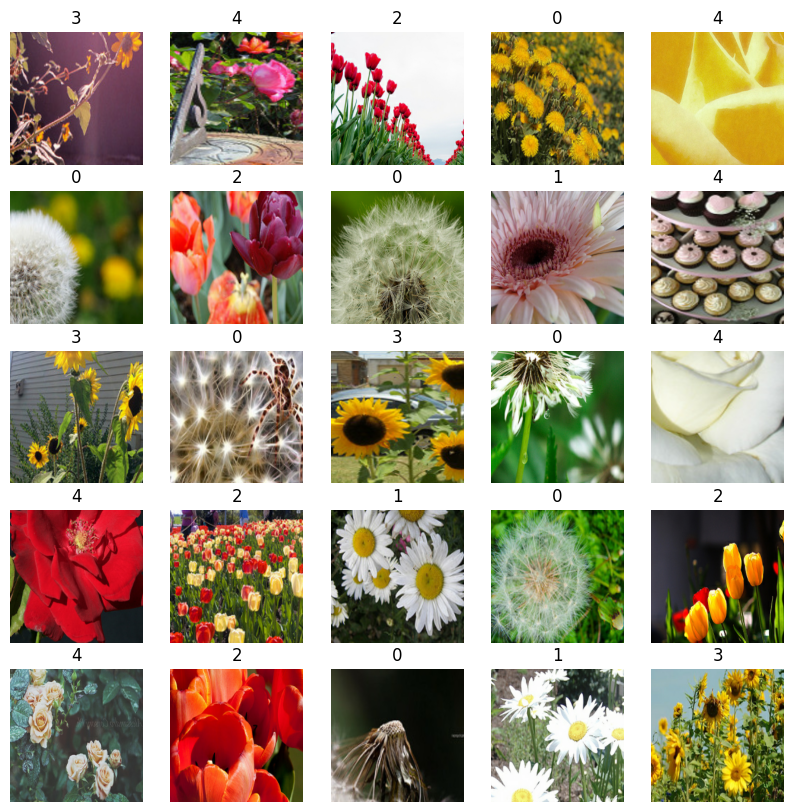

In [7]:
image_batch, label_batch = next(iter(pipeline_train))

plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(image_batch[n])
    plt.title(label_batch[n].numpy())
    plt.axis("off")

###Load pretrained TF-Hub model into a kerasLayer

In [8]:
bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_module = hub.KerasLayer(bit_model_url)

###Creating BigTransfer BiT model

In [9]:
class MyBiTModel(keras.Model):
    def __init__(self, num_classes, module, **kwargs):
        super().__init__(**kwargs)

        self.num_classes = num_classes
        self.head = keras.layers.Dense(num_classes, kernel_initializer="zeros")
        self.bit_model = module

    def call(self, images):
        bit_embedding = self.bit_model(images)
        return self.head(bit_embedding)


model = MyBiTModel(num_classes=NUM_CLASSES, module=bit_module)

###Define Optimizer and Loss

In [10]:
learning_rate = 0.003 * BATCH_SIZE / 512

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        learning_rate,
        learning_rate * 0.1,
        learning_rate * 0.01,
        learning_rate * 0.001,
    ],
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

###Compile the Model

In [11]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

Setup callbacks

In [12]:
train_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=2, restore_best_weights=True
    )
]

###Train the model

In [13]:
history = model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    epochs = 1,
    #epochs=int(SCHEDULE_LENGTH / STEPS_PER_EPOCH),
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=pipeline_validation,
    callbacks=train_callbacks,
)

10/10 [==============================] - 781s 83s/step - loss: 0.7418 - accuracy: 0.7875 - val_loss: 0.1848 - val_accuracy: 0.9600


###Evaluate the model

In [15]:
accuracy = model.evaluate(pipeline_validation)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))

9/9 [==============================] - 532s 58s/step - loss: 0.1848 - accuracy: 0.9600
Accuracy: 96.00%
